In [1]:
import numpy as np
import pandas as pd
from graphviz import Digraph, Source
from sklearn.tree import export_graphviz, DecisionTreeClassifier

### Dataset sintético

In [2]:
data = {
    'idade': [22, 35, 26, 45, 27, 50, 29, 41, 33, 38, 24, 48],
    'fumante': [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
    'pressao': ['alta', 'baixa', 'normal', 'alta', 'baixa', 'normal',
                'normal', 'alta', 'baixa', 'baixa', 'normal', 'alta'],
    'doenca':  [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
}
df = pd.DataFrame(data)
df.head(2)

,idade,fumante,pressao,doenca
0,22,0,alta,0
1,35,1,baixa,1


In [3]:
df_encoded = pd.get_dummies(df, columns=['pressao'], drop_first=True)
X = df_encoded.drop(columns='doenca')
y = df_encoded['doenca']

X = X.applymap(lambda x: int(x) if isinstance(x, (bool, np.bool_)) else x)

df_final = pd.concat([X, y], axis=1)
df_final

/tmp/ipykernel_85691/191564625.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, (bool, np.bool_)) else x)


,idade,fumante,pressao_baixa,pressao_normal,doenca
0,22,0,0,0,0
1,35,1,1,0,1
2,26,0,0,1,0
3,45,1,0,0,1
4,27,0,1,0,1
5,50,1,0,1,1
6,29,1,0,1,1
7,41,0,0,0,0
8,33,1,1,0,1
9,38,0,1,0,0


### Funções auxiliares para calcular o índice Gini

In [4]:
def gini_impurity(y):
    prob = y.value_counts(normalize=True)
    return 1 - sum(prob ** 2)

def weighted_gini(groups):
    total = sum(len(group) for group in groups)
    return sum((len(group) / total) * gini_impurity(group) for group in groups)

### Função para encontrar a melhor divisão

In [5]:
def melhor_divisao(df, target, features):
    melhor_gini = float('inf') # Inicializa o melhor Gini (infinito)
    melhor_feature = None
    melhor_corte = None
    
    for feature in features:
        valores_unicos = sorted(df[feature].unique()) # obtém e ordena todos os valores únicos dessa feature 
        cortes = [(valores_unicos[i] + valores_unicos[i+1]) / 2 for i in range(len(valores_unicos)-1)] # possíveis pontos de corte
        for corte in cortes: # 
            # Separa o target em dois grupos: <= corte e > corte
            esquerda = df[df[feature] <= corte][target]
            direita = df[df[feature] > corte][target]
            gini = weighted_gini([esquerda, direita]) # calcula o gini ponderado
            if gini < melhor_gini:
                melhor_gini = gini
                melhor_feature = feature
                melhor_corte = corte
                    
    return melhor_feature, melhor_corte, melhor_gini

### Função recursiva para construir a árvore

In [9]:
def construir_arvore(df, target, features):
    if len(df[target].unique()) == 1: # parada de parada: todos os exemplos têm a mesma classe
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}  # nó folha com a classe final
    
    feature, corte, gini = melhor_divisao(df, target, features)  # encontra melhor variável e corte

    if feature is None:
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}  # nó folha se não há divisão útil
    
    # Usar o melhor corte numérico (categóricos já viraram binários no one-hot encoding - ou seja, "melhor corte" = 0.5)
    esquerda_df = df[df[feature] <= corte]  # lado esquerdo: <= corte
    direita_df = df[df[feature] > corte]    # lado direito: > corte
    
    return {
        'folha': False,  # marca que este nó não é folha
        'feature': feature,  # qual variável foi usada
        'corte': corte,  # qual corte foi escolhido
        'gini': gini,  # valor do Gini neste nó
        'esquerda': construir_arvore(esquerda_df, target, features),  # subárvore esquerda
        'direita': construir_arvore(direita_df, target, features)    # subárvore direita
    }

### Função para visualizar árvore com graphviz

In [10]:
# Desenhar árvore manual com Graphviz
def desenhar_arvore(no, grafo, nome='root'):
    if no['folha']:
        classe_nome = "Doente" if no['classe'] == 1 else "Não Doente"
        grafo.node(nome, f"Classe: {classe_nome}", shape='box')
    else:
        if no['corte'] is not None:
            label = f"{no['feature']} <= {no['corte']:.1f}"
        else:
            label = f"{no['feature']}"
        grafo.node(nome, label)
        
        # Esquerda
        desenhar_arvore(no['esquerda'], grafo, nome + 'L')
        grafo.edge(nome, nome + 'L', label='Sim')
        
        # Direita
        desenhar_arvore(no['direita'], grafo, nome + 'R')
        grafo.edge(nome, nome + 'R', label='Não')

In [13]:
# Construir árvore
arvore_manual = construir_arvore(df_final, 'doenca', df_final.drop('doenca', axis=1).columns)
arvore_manual

{'folha': False,
 'feature': 'fumante',
 'corte': 0.5,
 'gini': 0.13888888888888884,
 'esquerda': {'folha': False,
  'feature': 'pressao_baixa',
  'corte': 0.5,
  'gini': 0.16666666666666666,
  'esquerda': {'folha': True, 'classe': 0},
  'direita': {'folha': False,
   'feature': 'idade',
   'corte': 32.5,
   'gini': 0.0,
   'esquerda': {'folha': True, 'classe': 1},
   'direita': {'folha': True, 'classe': 0}}},
 'direita': {'folha': True, 'classe': 1}}

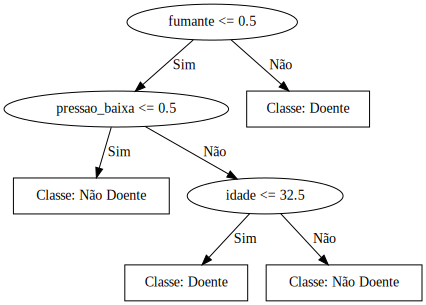

In [14]:
# Visualizar árvore
grafo_manual = Digraph()
desenhar_arvore(arvore_manual, grafo_manual)
display(grafo_manual)

### Treinar uma árvore com sklearn

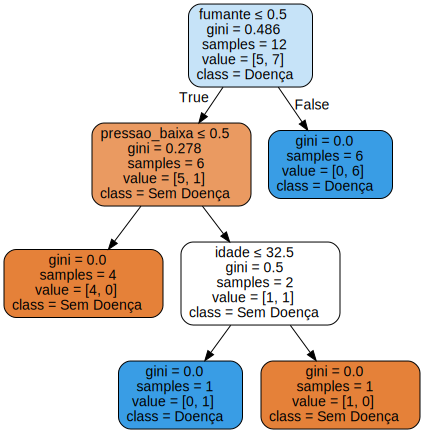

In [12]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X, y)

# Visualizar a árvore final
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names=['Sem Doença', 'Doença'],
    filled=True, rounded=True, special_characters=True
)
graph = Source(dot_data)
display(graph)

### Outras possibilidades

##### 1. Adicionar max_depth
- Limitar a profundidade máxima da árvore para evitar que ela cresça demais.

##### 2. Adicionar min_samples_split
- Não dividir um nó se ele tiver menos que, por exemplo, 2 ou 5 amostras.
- Isso ajuda a evitar nós super pequenos.

##### 3. Contar número total de nós
- Adicionar uma contagem de quantos nós (folhas + internos) foram criados no final.

##### 4. Calcular e imprimir a altura da árvore
- Altura = maior profundidade alcançada.
- Eles podem fazer isso percorrendo a estrutura retornada.

##### 5. Calcular acurácia na árvore montada
- Passar os dados novamente pela árvore manual e contar quantas previsões acertam.

##### 6. Printar a árvore em texto
- Ao invés de usar só graphviz, fazer uma versão simples que printa a árvore como texto indentado:

##### 7. Calcular o importance score de cada feature
- Quantas vezes ela aparece nos splits.

##### 8. Adicionar parada por ganho mínimo de Gini
- Ex.: só dividir se reduzir pelo menos X% do Gini.

---
---
---
---
---
---
---
---
---
---

#### Max depth

In [15]:
def construir_arvore(df, target, features, profundidade=0, max_depth=3):
    # Parada se todos têm a mesma classe ou atingiu profundidade máxima
    if len(df[target].unique()) == 1 or profundidade == max_depth:
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}

    feature, corte, gini = melhor_divisao(df, target, features)  # encontra melhor variável e corte

    if feature is None:
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}

    # Usar o melhor corte numérico (categóricos já viraram binários no one-hot encoding - ou seja, "melhor corte" = 0.5)
    esquerda_df = df[df[feature] <= corte]
    direita_df = df[df[feature] > corte]

    return {
        'folha': False,
        'feature': feature,
        'corte': corte,
        'gini': gini,
        'esquerda': construir_arvore(esquerda_df, target, features, profundidade + 1, max_depth),
        'direita': construir_arvore(direita_df, target, features, profundidade + 1, max_depth)
    }


#### Min samples split

In [16]:
def construir_arvore(df, target, features, min_samples_split=2):
    # Parada se todos têm a mesma classe ou poucos exemplos para dividir
    if len(df[target].unique()) == 1 or len(df) < min_samples_split:
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}

    feature, corte, gini = melhor_divisao(df, target, features)  # encontra melhor variável e corte

    if feature is None:
        classe = df[target].mode()[0]  # pega a classe mais frequente (moda)
        return {'folha': True, 'classe': classe}

    # Usar o melhor corte numérico (categóricos já viraram binários no one-hot encoding - ou seja, "melhor corte" = 0.5)
    esquerda_df = df[df[feature] <= corte]
    direita_df = df[df[feature] > corte]

    return {
        'folha': False,
        'feature': feature,
        'corte': corte,
        'gini': gini,
        'esquerda': construir_arvore(esquerda_df, target, features, min_samples_split=min_samples_split),
        'direita': construir_arvore(direita_df, target, features, min_samples_split=min_samples_split)
    }


#### Contagem de número de nós e altura

In [17]:
def construir_arvore_com_contagem(df, target, features):
    if len(df[target].unique()) == 1:
        classe = df[target].mode()[0]
        return {'folha': True, 'classe': classe, 'n_nos': 1}

    feature, corte, gini = melhor_divisao(df, target, features)

    if feature is None:
        classe = df[target].mode()[0]
        return {'folha': True, 'classe': classe, 'n_nos': 1}

    esquerda = construir_arvore_com_contagem(df[df[feature] <= corte], target, features)
    direita = construir_arvore_com_contagem(df[df[feature] > corte], target, features)

    total_nos = 1 + esquerda['n_nos'] + direita['n_nos']

    return {
        'folha': False,
        'feature': feature,
        'corte': corte,
        'gini': gini,
        'esquerda': esquerda,
        'direita': direita,
        'n_nos': total_nos  # soma total de nós na subárvore
    }


#### Juntando as novas funcionalidades

In [18]:
def construir_arvore_completa(df, target, features, profundidade=0, max_depth=None, min_samples_split=2):
    # Parada: todos têm mesma classe, atingiu profundidade máxima, ou poucos exemplos
    if len(df[target].unique()) == 1 or \
       (max_depth is not None and profundidade == max_depth) or \
       len(df) < min_samples_split:
        classe = df[target].mode()[0]
        return {'folha': True, 'classe': classe, 'n_nos': 1, 'altura': 1}

    feature, corte, gini = melhor_divisao(df, target, features)

    if feature is None:
        classe = df[target].mode()[0]
        return {'folha': True, 'classe': classe, 'n_nos': 1, 'altura': 1}

    esquerda = construir_arvore_completa(
        df[df[feature] <= corte], target, features, profundidade + 1, max_depth, min_samples_split)
    direita = construir_arvore_completa(
        df[df[feature] > corte], target, features, profundidade + 1, max_depth, min_samples_split)

    total_nos = 1 + esquerda['n_nos'] + direita['n_nos']
    altura_subarvore = 1 + max(esquerda['altura'], direita['altura'])

    return {
        'folha': False,
        'feature': feature,
        'corte': corte,
        'gini': gini,
        'esquerda': esquerda,
        'direita': direita,
        'n_nos': total_nos,        # soma total de nós na subárvore
        'altura': altura_subarvore # maior profundidade da subárvore
    }
